In [ ]:
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch.nn import CrossEntropyLoss
from torch.utils.data import Dataset

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
)
from sklearn.utils.class_weight import compute_class_weight
from sklearn.calibration import LabelEncoder

from transformers import (
    RobertaTokenizer,
    RobertaForSequenceClassification,
    Trainer,
    TrainingArguments,
    EarlyStoppingCallback,
)

In [20]:
lyrics_folder = "/Users/malgosielska/Studies/Sem 1 TAI/ML/Multimodal-classification/dataset - original/Lyrics"
labels_file = "/Users/malgosielska/Studies/Sem 1 TAI/ML/Multimodal-classification/klasy_mapped.txt"

In [21]:
all_labels = []
with open(labels_file, "r", encoding="utf-8") as f:
    all_labels = f.readlines()

all_labels = [label.strip() for label in all_labels]
print(len(all_labels))
all_labels[:10]

903


['negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative',
 'negative']

In [22]:
lyric_files = [f for f in os.listdir(lyrics_folder) if f.lower().endswith(".txt")]

texts = []
labels = []

for idx in range(1, 904):  # 001 to 903
    filename = f"{idx:03}.txt"
    filepath = os.path.join(lyrics_folder, filename)
    if os.path.exists(filepath):
        with open(filepath, "r", encoding="utf-8") as f:
            text = f.read().strip()
            texts.append(text)
            labels.append(all_labels[idx - 1])

print(f"Loaded {len(texts)} lyrics and {len(labels)} labels.")

texts[:10], labels[:10], len(texts), len(lyric_files)

Loaded 764 lyrics and 764 labels.


(["Mama he treats your daughter mean \nMama he treats your daughter mean \nMama he treats your daughter mean \nHe's the meanest man I've ever seen \n\nMama he treats me badly \nMakes me love him madly \nMama he takes my money \nMakes me call him honey \n\nMama he can't be trusted \nHe makes me so disgusted \nAll of my friends they don't understand \nWhat's the matter with this man \n\nI tell you mama he treats your daughter mean \nMama he treats your daughter mean \nMama he treats your daughter mean \nHe's the meanest man I've ever seen \n\nMama this man is lazy \nAlmost drives me crazy \nMama he makes me squeeze him \nStill my squeezes don't please him \n\nMama my heart is aching \nI believe it's breaking \nI've stood all that I can stand \nWhat's the matter with this man? \n\nI tell you Mama he treats your daughter mean \nMama he treats your daughter mean \nMama he treats your daughter mean \nHe's the meanest man I've ever seen",
  'I plopped down in my easy chair and turned on Chann

In [23]:
label_encoder = LabelEncoder()
label_ids = label_encoder.fit_transform(labels)

label_classes = label_encoder.classes_

for i, class_name in enumerate(label_classes):
    count = np.sum(label_ids == i)
    print(f"{class_name} (ID={i}): {count} przykładów")

label_classes

negative (ID=0): 170 przykładów
nostalgic (ID=1): 224 przykładów
positive (ID=2): 370 przykładów


array(['negative', 'nostalgic', 'positive'], dtype='<U9')

In [24]:
class_weights = compute_class_weight(
    class_weight="balanced", classes=np.unique(label_ids), y=label_ids
)

print("Class weights:", class_weights)
class_weights = torch.tensor(class_weights, dtype=torch.float)

Class weights: [1.49803922 1.13690476 0.68828829]


In [25]:
# First split: 80% train, 20% val+test
texts_train, texts_val_test, labels_train, labels_val_test = train_test_split(
    texts, label_ids, test_size=0.2, stratify=label_ids, random_state=42
)

# Then split val+test: 50/50 → 10% val, 10% test
texts_val, texts_test, labels_val, labels_test = train_test_split(
    texts_val_test,
    labels_val_test,
    test_size=0.5,
    stratify=labels_val_test,
    random_state=42,
)

(
    len(texts_train),
    len(texts_val),
    len(texts_test),
    len(labels_train),
    len(labels_val),
    len(labels_test),
)

(611, 76, 77, 611, 76, 77)

In [ ]:
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")


def tokenize_texts(texts):
    return tokenizer(
        texts, padding=True, truncation=True, max_length=512, return_tensors="pt"
    )


tokenizer.padding_side = "right"
tokenizer.pad_token = tokenizer.eos_token

train_encodings = tokenize_texts(texts_train)
val_encodings = tokenize_texts(texts_val)
test_encodings = tokenize_texts(texts_test)

In [ ]:
class LyricsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item["labels"] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)


train_dataset = LyricsDataset(train_encodings, labels_train)
val_dataset = LyricsDataset(val_encodings, labels_val)
test_dataset = LyricsDataset(test_encodings, labels_test)

In [ ]:
class BertWithClassWeights(RobertaForSequenceClassification):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        loss_fct = CrossEntropyLoss(weight=class_weights.to(model.device))
        loss = loss_fct(logits, labels)
        return (loss, outputs) if return_outputs else loss

In [29]:
model = BertWithClassWeights.from_pretrained(
    "roberta-base", num_labels=len(label_classes)
)

model.config.pad_token_id = tokenizer.pad_token_id

Some weights of BertWithClassWeights were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=1e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=20,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True,
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = logits.argmax(axis=1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted"),
    }


trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
)

trainer.train()

/Users/malgosielska/Studies/Sem 1 TAI/ML/Multimodal-classification/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.037500,0.957449,0.578947,0.479617
2,0.932300,0.886044,0.578947,0.503120
3,0.759400,1.159605,0.513158,0.483188
4,0.499800,1.002357,0.592105,0.579971
5,0.408900,1.085163,0.605263,0.592893
6,0.372200,1.219799,0.592105,0.596933
7,0.217100,1.609902,0.513158,0.511134
8,0.118100,1.501824,0.605263,0.605574
9,0.248000,1.822173,0.618421,0.621996
10,0.115600,2.031599,0.618421,0.621935


/Users/malgosielska/Studies/Sem 1 TAI/ML/Multimodal-classification/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/malgosielska/Studies/Sem 1 TAI/ML/Multimodal-classification/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/malgosielska/Studies/Sem 1 TAI/ML/Multimodal-classification/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/malgosielska/Studies/Sem 1 TAI/ML/Multimodal-classification/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning

TrainOutput(global_step=924, training_loss=0.4292797227450586, metrics={'train_runtime': 5494.6296, 'train_samples_per_second': 2.224, 'train_steps_per_second': 0.28, 'total_flos': 1929147578781696.0, 'train_loss': 0.4292797227450586, 'epoch': 12.0})

In [31]:
results = trainer.evaluate(test_dataset)
print("Test Results:", results)

/Users/malgosielska/Studies/Sem 1 TAI/ML/Multimodal-classification/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test Results: {'eval_loss': 0.9962362051010132, 'eval_accuracy': 0.7142857142857143, 'eval_f1': 0.7148794063079777, 'eval_runtime': 3.6762, 'eval_samples_per_second': 20.946, 'eval_steps_per_second': 2.72, 'epoch': 12.0}


/Users/malgosielska/Studies/Sem 1 TAI/ML/Multimodal-classification/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


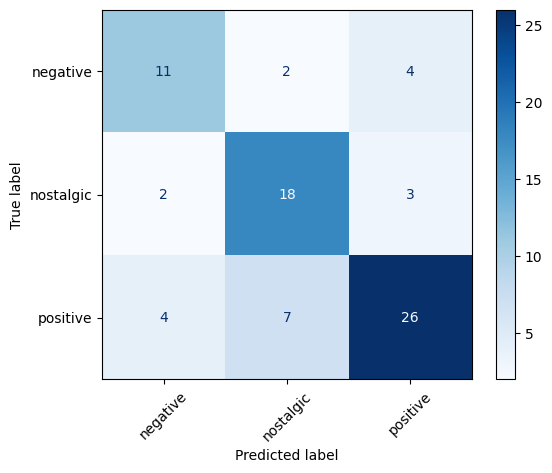

              precision    recall  f1-score   support

    negative       0.65      0.65      0.65        17
   nostalgic       0.67      0.78      0.72        23
    positive       0.79      0.70      0.74        37

    accuracy                           0.71        77
   macro avg       0.70      0.71      0.70        77
weighted avg       0.72      0.71      0.71        77



In [ ]:
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=label_encoder.classes_
)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))

In [ ]:
MODEL_NAME = "bert-emotion-classifier-3-classes-v3"

model.save_pretrained(MODEL_NAME)
tokenizer.save_pretrained(MODEL_NAME)

('bert-emotion-classifier-3-classes-v3/tokenizer_config.json',
 'bert-emotion-classifier-3-classes-v3/special_tokens_map.json',
 'bert-emotion-classifier-3-classes-v3/vocab.json',
 'bert-emotion-classifier-3-classes-v3/merges.txt',
 'bert-emotion-classifier-3-classes-v3/added_tokens.json')

## Saving model to HuggingFace

In [37]:
from huggingface_hub import login, create_repo, upload_folder

# login()  # Wklej swój token z https://huggingface.co/settings/tokens

HF_USERNAME = "malgosielska"
MODEL_ID = "bert-emotion-classifier-3-classes"

LOCAL_MODEL_DIR = "bert-emotion-classifier-3-classes"
REMOTE_REPO_ID = f"{HF_USERNAME}/{MODEL_ID}"

create_repo(repo_id=REMOTE_REPO_ID, exist_ok=True)

upload_folder(
    repo_id=REMOTE_REPO_ID,
    folder_path=LOCAL_MODEL_DIR,
    path_in_repo=".",
)

print(f"✅ Model wysłany na Hugging Face: https://huggingface.co/{REMOTE_REPO_ID}")

No files have been modified since last commit. Skipping to prevent empty commit.


✅ Model wysłany na Hugging Face: https://huggingface.co/malgosielska/bert-emotion-classifier-3-classes


## Model analysis

### Using model from HuggingFace

In [38]:
from transformers import RobertaTokenizer, RobertaForSequenceClassification

HF_MODEL_PATH = "malgosielska/bert-emotion-classifier-3-classes"

tokenizer = RobertaTokenizer.from_pretrained(HF_MODEL_PATH)
model = RobertaForSequenceClassification.from_pretrained(HF_MODEL_PATH)
model.eval()

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=2)
      (position_embeddings): Embedding(514, 768, padding_idx=2)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [39]:
trainer = Trainer(model=model, compute_metrics=compute_metrics)
results = trainer.evaluate(test_dataset)
print("Test results:", results)

/Users/malgosielska/Studies/Sem 1 TAI/ML/Multimodal-classification/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Test results: {'eval_loss': 0.7728451490402222, 'eval_model_preparation_time': 0.0008, 'eval_accuracy': 0.6883116883116883, 'eval_f1': 0.6878817642759584, 'eval_runtime': 3.6689, 'eval_samples_per_second': 20.987, 'eval_steps_per_second': 2.726}


/Users/malgosielska/Studies/Sem 1 TAI/ML/Multimodal-classification/.venv/lib/python3.9/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


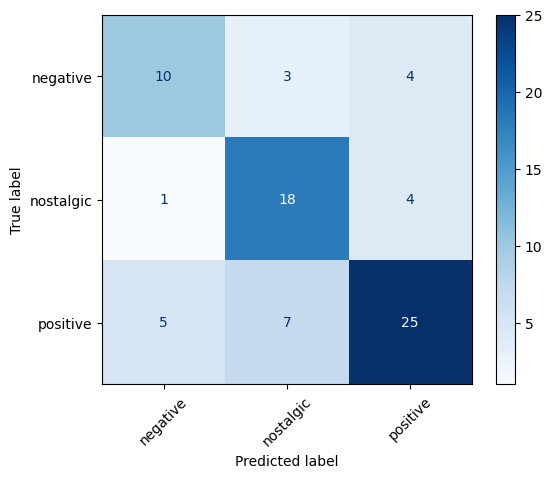

              precision    recall  f1-score   support

    negative       0.62      0.59      0.61        17
   nostalgic       0.64      0.78      0.71        23
    positive       0.76      0.68      0.71        37

    accuracy                           0.69        77
   macro avg       0.68      0.68      0.68        77
weighted avg       0.69      0.69      0.69        77



In [40]:
preds = trainer.predict(test_dataset)
y_true = preds.label_ids
y_pred = preds.predictions.argmax(-1)

cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm, display_labels=label_encoder.classes_
)
disp.plot(cmap="Blues", xticks_rotation=45)
plt.show()

print(classification_report(y_true, y_pred, target_names=label_encoder.classes_))